<a href="https://colab.research.google.com/github/Buddhi1130/Deeplearning_A2/blob/main/cnn_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset (change path to your dataset if required)
dataset = datasets.CIFAR10(root='./data', train=True, transform=data_transforms, download=True)

# Splitting dataset for validation and training
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 34.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Choose Model (ResNet-18 as example)
def initialize_model(model_name, num_classes=10):
    if model_name == "resnet":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Initialize ResNet-18 for example
model = initialize_model("resnet")
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD with a learning rate of 0.01 and momentum)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_acc_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to("cuda"), labels.to("cuda")
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_acc_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    return train_acc_history, val_acc_history


Epoch 1/3, Train Accuracy: 44.59%, Val Accuracy: 56.82%
Epoch 2/3, Train Accuracy: 66.92%, Val Accuracy: 71.90%
Epoch 3/3, Train Accuracy: 76.06%, Val Accuracy: 75.48%


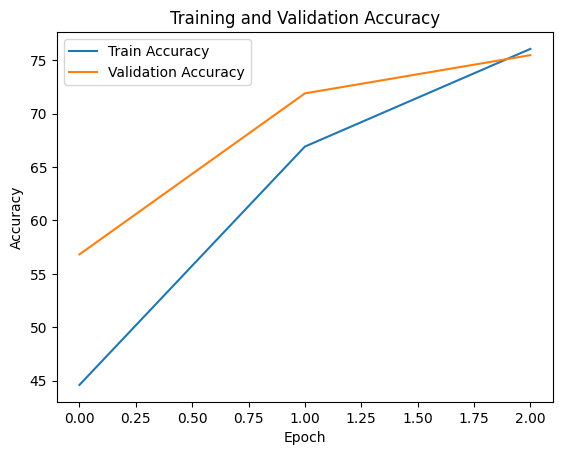

In [ ]:
def plot_accuracy(train_acc, val_acc):
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')
    plt.show()

# Train and plot results
train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=3)
plot_accuracy(train_acc, val_acc)


In [7]:
# Load Test Dataset and Evaluate
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=data_transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

evaluate_model(model, test_loader)


Files already downloaded and verified
Test Accuracy: 75.43%


Files already downloaded and verified
Training resnet...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/1, Train Accuracy: 42.06%, Val Accuracy: 55.29%


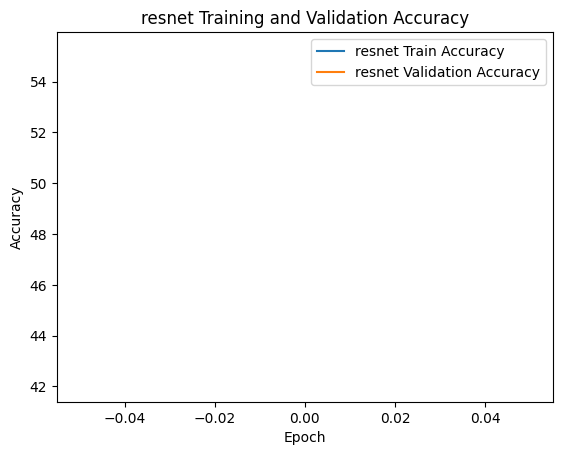

Training alexnet...
Epoch 1/1, Train Accuracy: 28.89%, Val Accuracy: 35.21%


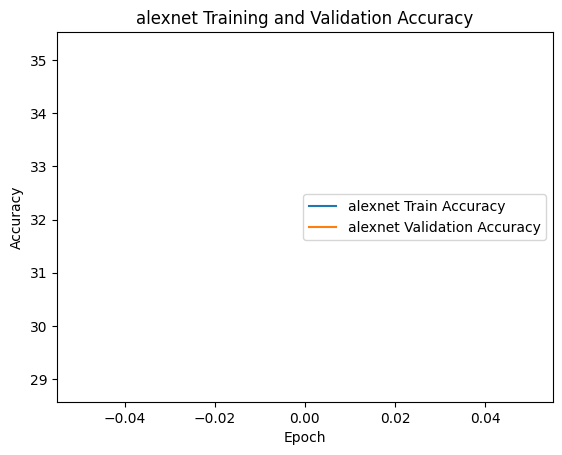

Training mobilenet...
Epoch 1/1, Train Accuracy: 41.48%, Val Accuracy: 60.13%


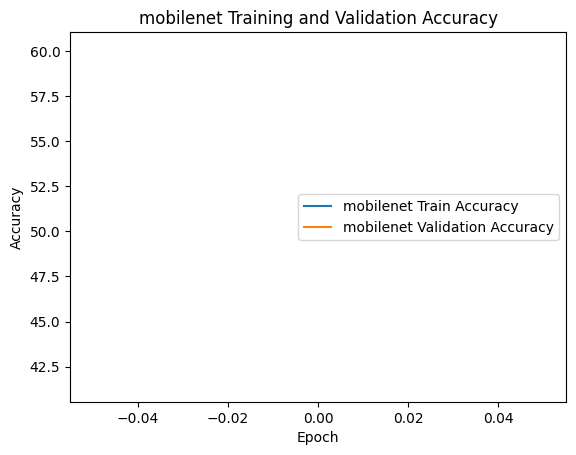

Text(0.5, 1.0, 'Validation Accuracy Comparison Across Models')

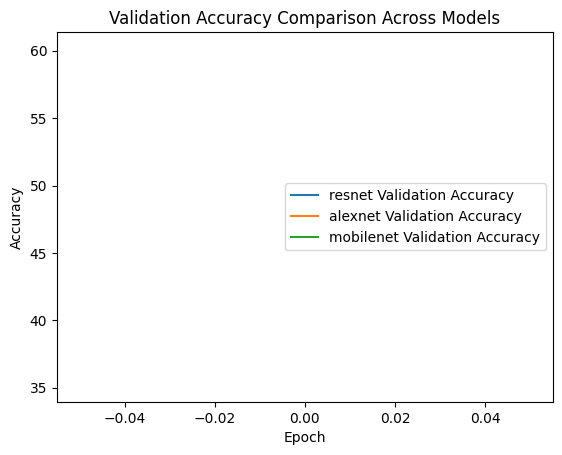

In [8]:
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load CIFAR-10 Dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=data_transforms, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Define the model initialization function
def initialize_model(model_name, num_classes=10):
    if model_name == "resnet":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_acc_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_acc_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

    return train_acc_history, val_acc_history

# Plot accuracy curves
def plot_accuracy(train_acc, val_acc, model_name):
    plt.plot(train_acc, label=f'{model_name} Train Accuracy')
    plt.plot(val_acc, label=f'{model_name} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.show()

# Experiment with different models and hyper-parameters
models_to_compare = ["resnet", "alexnet", "mobilenet"]
experiment_results = {}

for model_name in models_to_compare:
    print(f"Training {model_name}...")
    model = initialize_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1)
    experiment_results[model_name] = {"train_acc": train_acc, "val_acc": val_acc}
    plot_accuracy(train_acc, val_acc, model_name)

# Compare Validation Accuracy Across Models
for model_name, acc in experiment_results.items():
    plt.plot(acc["val_acc"], label=f'{model_name} Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Validation Accuracy Comparison Across Models')


In [9]:
import pandas as pd

# Convert experiment_results dictionary into a DataFrame for table format
data = {
    "Model": list(experiment_results.keys()),
    "Train Accuracy (%)": [values["train_acc"][0] for values in experiment_results.values()],
    "Validation Accuracy (%)": [values["val_acc"][0] for values in experiment_results.values()]
}

accuracy_df = pd.DataFrame(data)
accuracy_df


,Model,Train Accuracy (%),Validation Accuracy (%)
0,resnet,42.0600,55.29
1,alexnet,28.8875,35.21
2,mobilenet,41.4800,60.13
